In [1]:
import networkx as nx
import numpy as np
import pandas as pd

from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

import community as community_louvain

In [2]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

In [3]:
data = r'data/wilco_edgelist.csv'

df = pd.read_csv(data)

df.head()

,source,target
0,wilco,Wilco
1,wilco,Procedure word
2,wilco,Roger Wilco
3,wilco,Wilco (disambiguation)
4,wilco,Jeff Tweedy


In [4]:
G = nx.from_pandas_edgelist(df)

G.remove_edges_from(nx.selfloop_edges(G))

# use the ego network as the graph (to quickly remove noise) and radius to get to the right place
G = nx.ego_graph(G, 'Wilco', radius=2)

In [5]:
print(nx.info(G))

Graph with 166 nodes and 377 edges


# Graph Cleanup

In today's experimentation, I want to use edge betweenness centrality to see if I can use it to split up our Wilco network and make it more relevant to the band. Basically, I want to cut out stuff that is not related to Wilco (the band). Consider this network wrangling.

# Inspect the Core

For this exercise, I will use the K_core with K at 3, because it gives us a neat network for use in this exercise.

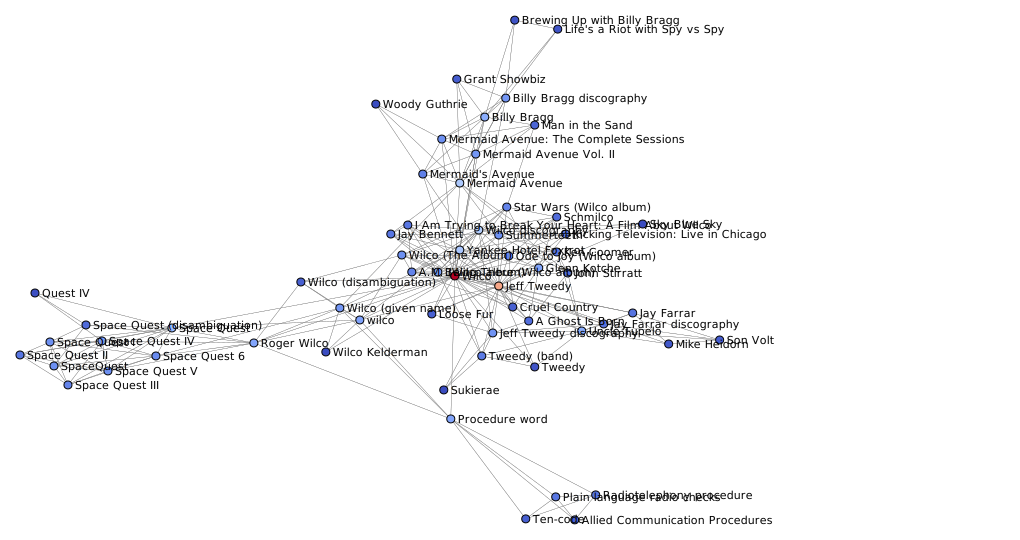

In [7]:
# draw the core

G = nx.k_core(G, 3)

draw_graph(G, node_size=4, font_size=11, show_names=True, edge_width=0.3)

# Introducing Edge Betweenness Centrality

Edges can also have a Betweenness Centrality value. Edges with a high betweenness centrality are edges that are most used to get from one node to another. They are edges that sit on the most shortest paths. Let's identify them, and then see if cutting them can be useful for splitting this network up. We will likely need a combination of manual cuts and edge betweenness cuts to clean this up. There are some nodes that don't belong, and some edges that will clean up the rest of the way.

Before starting with the manual way, let's just see what the edge betweenness centrality values look like.

In [8]:
edge_betw_cent = nx.edge_betweenness_centrality(G)

edge_betw_cent_df = pd.DataFrame().from_dict(edge_betw_cent, orient='index')
edge_betw_cent_df.columns = ['edge_betweenness_centrality']
edge_betw_cent_df.sort_values('edge_betweenness_centrality', inplace=True, ascending=False)

edge_betw_cent_df.head(10)

,edge_betweenness_centrality
"(Wilco, Space Quest)",0.164367
"(Procedure word, Wilco)",0.105211
"(Billy Bragg, Wilco)",0.074926
"(Wilco, Roger Wilco)",0.055668
"(Wilco, Mermaid Avenue: The Complete Sessions)",0.034639
"(Wilco, Jay Farrar)",0.032235
"(Mermaid Avenue Vol. II, Wilco)",0.031663
"(Wilco, Mermaid Avenue)",0.031663
"(Allied Communication Procedures, Procedure word)",0.031330
"(Procedure word, Ten-code)",0.031330


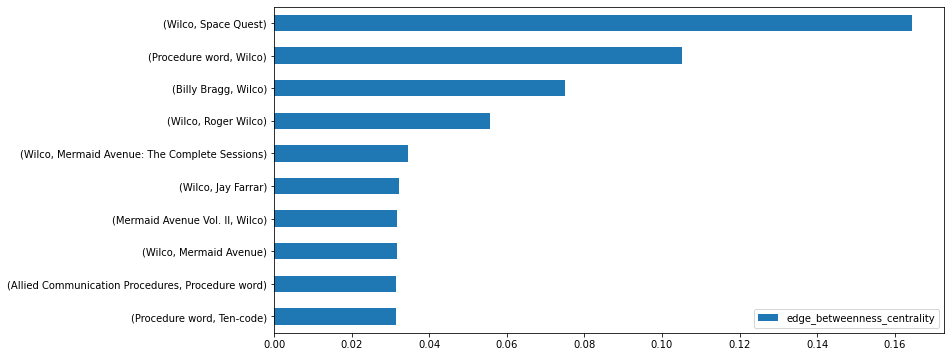

In [9]:
edge_betw_cent_df.head(10).plot.barh(figsize=(12,6)).invert_yaxis()

I can see that it's a mix of relevant and non-relevant. First, I'll use some of my own domain knowledge to remove nodes that shouldn't be in the network. That alone will shatter the graph and make it easier for next steps of cleanup. By the end of this exercise, we should have a clean Wilco network to explore.

# Manually Removing Nodes

First, I'll visually identify nodes that are out of place. This is not a large network, so we can do that with our eyes. A better approach is to use centralities and page rank to identify important nodes, then identify out of place nodes in the important nodes, then remove them. That'll shatter the network. Then look again, and repeat. Repeat until you are done and have a clean network. It is iterative work, like a craft.

I'll draw the graph again and manually identify nodes that are out of place.

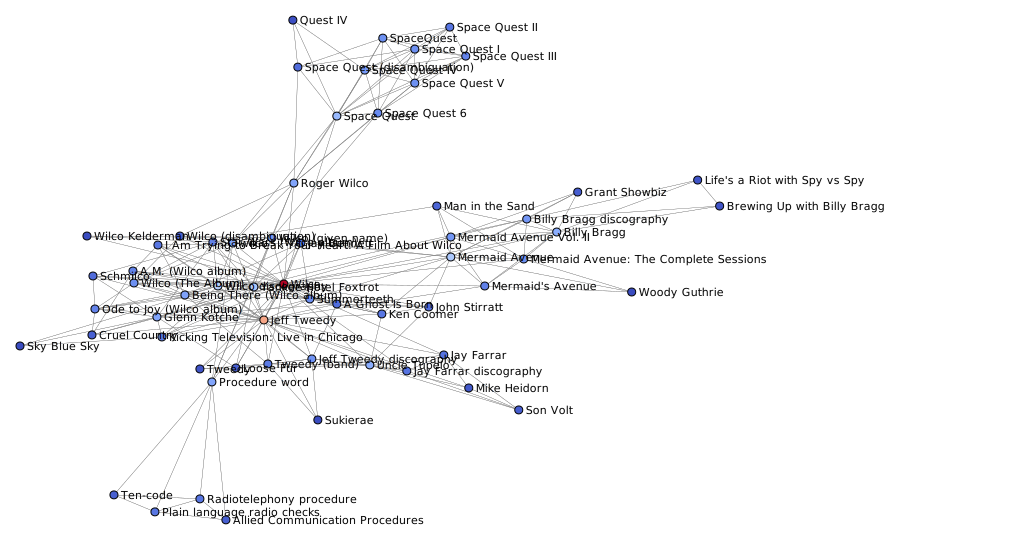

In [11]:
draw_graph(G, node_size=4, font_size=11, show_names=True, edge_width=0.3)

In [12]:
drop_nodes = ['wilco', 'Wilco (given name)', 'Wilco Kelderman', 'Wilco (disambiguation)', 'Wilco (given name)', 
              'Roger Wilco', 'Procedure word']

G.remove_nodes_from(drop_nodes)

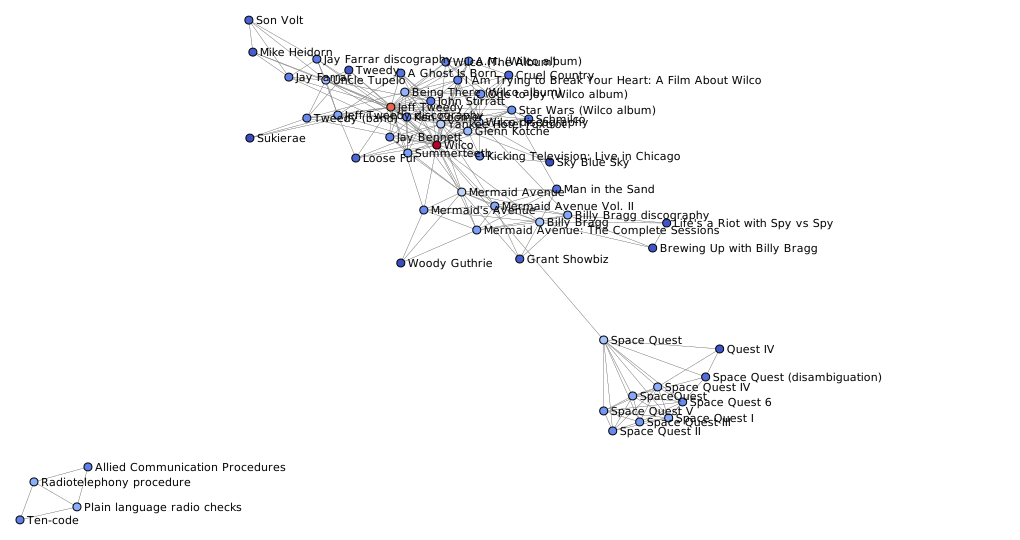

In [15]:
draw_graph(G, node_size=4, font_size=11, show_names=True, edge_width=0.3)

That's perfect! From here, all we have left is to remove the one problematic edge and the network will fly apart. From there, we keep the connected component that is related to Wilco, and we disregard the rest. That should leave us with a clean Wilco network.

In [16]:
edge_betw_cent = nx.edge_betweenness_centrality(G)

edge_betw_cent_df = pd.DataFrame().from_dict(edge_betw_cent, orient='index')
edge_betw_cent_df.columns = ['edge_betweenness_centrality']
edge_betw_cent_df.sort_values('edge_betweenness_centrality', inplace=True, ascending=False)

edge_betw_cent_df.head(10)

,edge_betweenness_centrality
"(Wilco, Space Quest)",0.276094
"(Billy Bragg, Wilco)",0.072773
"(Wilco, Mermaid Avenue)",0.035693
"(Wilco, Mermaid Avenue: The Complete Sessions)",0.034491
"(Mermaid Avenue Vol. II, Wilco)",0.031030
"(Wilco, Jay Farrar)",0.030336
"(Quest IV, Space Quest)",0.030079
"(Billy Bragg discography, Wilco discography)",0.029510
"(Space Quest (disambiguation), Space Quest)",0.029349
"(Space Quest II, Space Quest)",0.028956


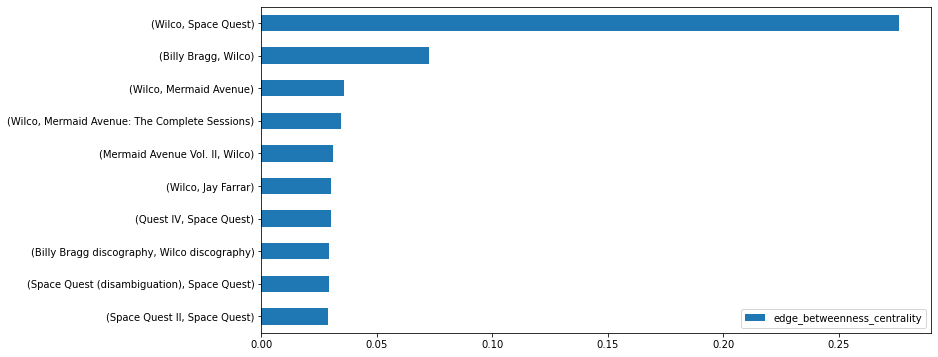

In [17]:
edge_betw_cent_df.head(10).plot.barh(figsize=(12,6)).invert_yaxis()

Now compare the edge betweenness centralities from before and now. The edge between Space Quest and Wilco is still at the top, and much more noticeable. If we snip that top edge, the network will shatter and we will be nearly done.

In [18]:
drop_edge = edge_betw_cent_df[0:1].index.values[0]

G.remove_edges_from([drop_edge]) # pass in a list

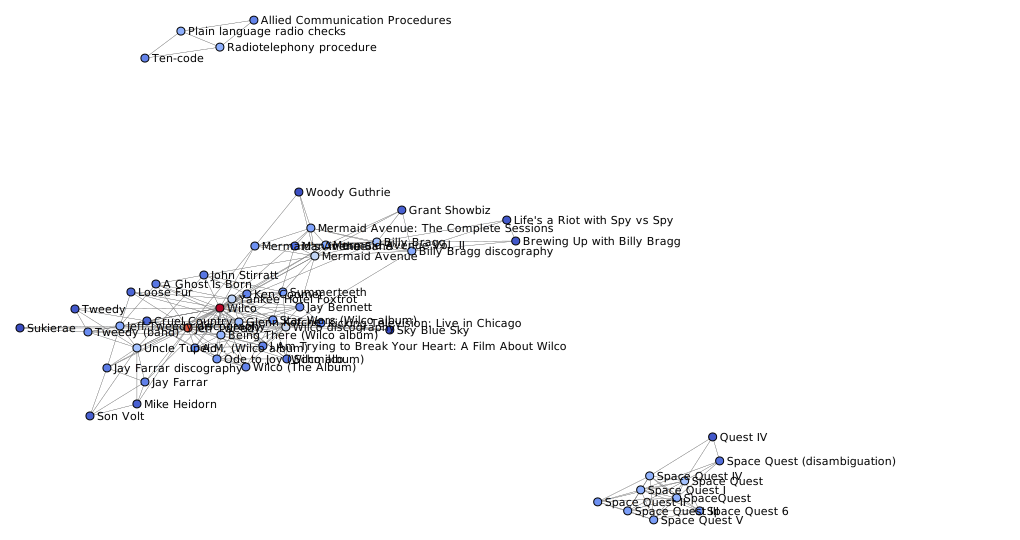

In [19]:
draw_graph(G, node_size=4, font_size=11, show_names=True, edge_width=0.3)

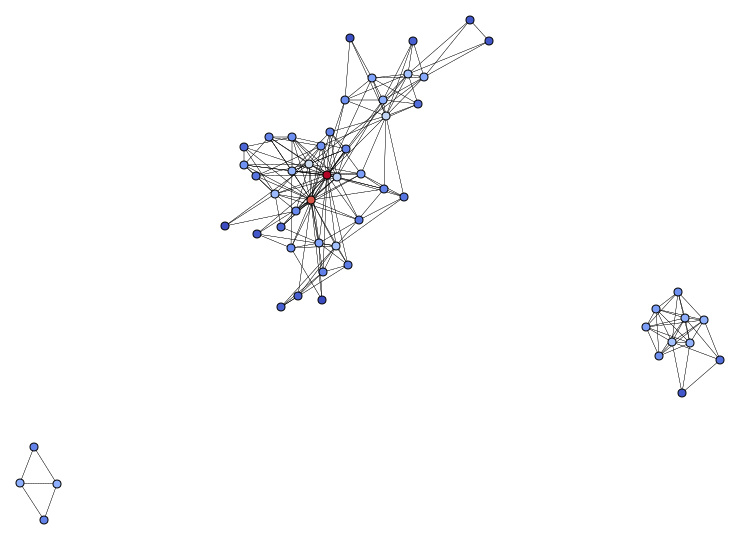

In [20]:
draw_graph(G, node_size=4, font_size=11, show_names=False, edge_width=0.3)

I can clearly see that the network has split into three connected components. We will keep the one that is related to the band Wilco, and we will disregard the rest. 

# Connected Components

In my book, I describe networks as having connected components that resemble islands and continents. Networks will often have one super cluster, then a bunch of large but smaller clusters, and many isolate nodes. I think of the three as continents, islands, and isolates. Isolates could be people on boats, if you want a mental picture.

In [21]:
components = list(nx.connected_components(G))

[len(c) for c in components]

[41, 10, 4]

There are now three connected components in the network. We can investigate them separately, easily. The first component has 41 nodes, the second has four nodes, and the third has ten. Look at the network visualization and see if you can already identify them.

Let's look at each of them, separately.

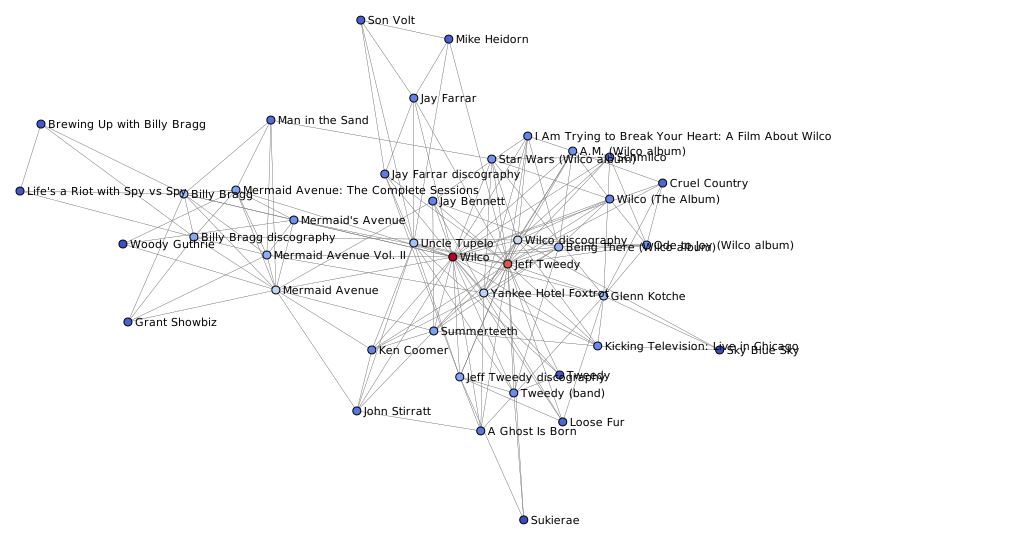

In [22]:
component = components[0]

G_check = G.subgraph(component)

draw_graph(G_check, node_size=4, font_size=11, show_names=True, edge_width=0.3)

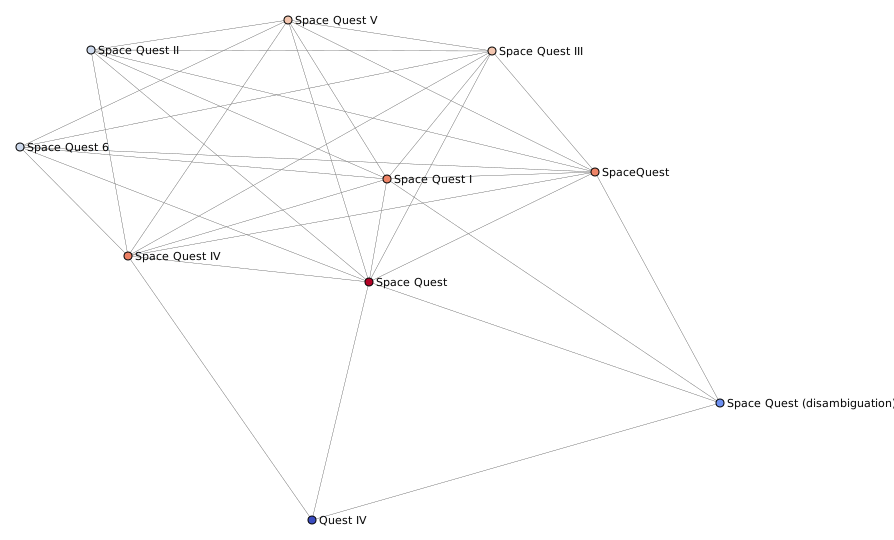

In [23]:
component = components[1]

G_check = G.subgraph(component)

draw_graph(G_check, node_size=4, font_size=11, show_names=True, edge_width=0.3)

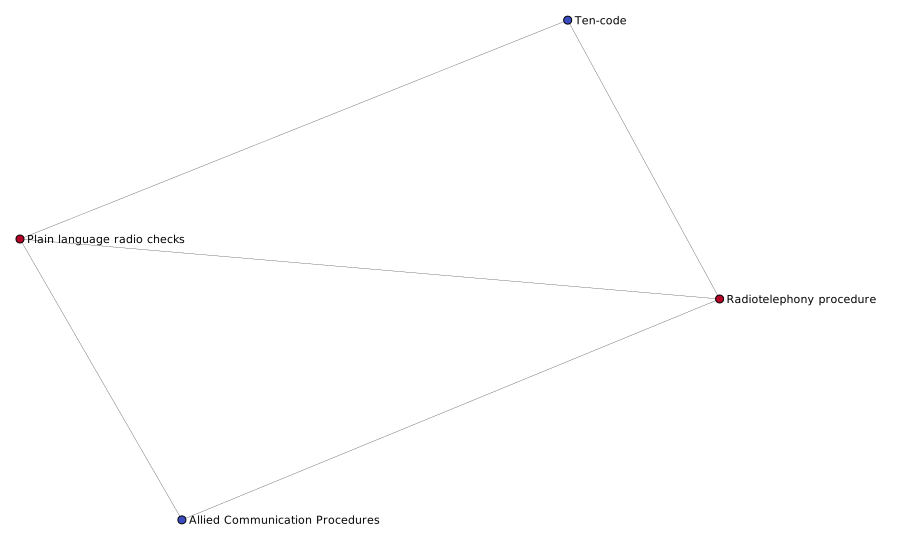

In [24]:
component = components[2]

G_check = G.subgraph(component)

draw_graph(G_check, node_size=4, font_size=11, show_names=True, edge_width=0.3)

# Keep the Wilco Subgraph

We've identified the Wilco subgraph by using connected components. Let's take that and use that as our Graph. Then we have a clean Wilco network, and centralities and communities will be more useful, in later analysis. Let's persist this network for later use.

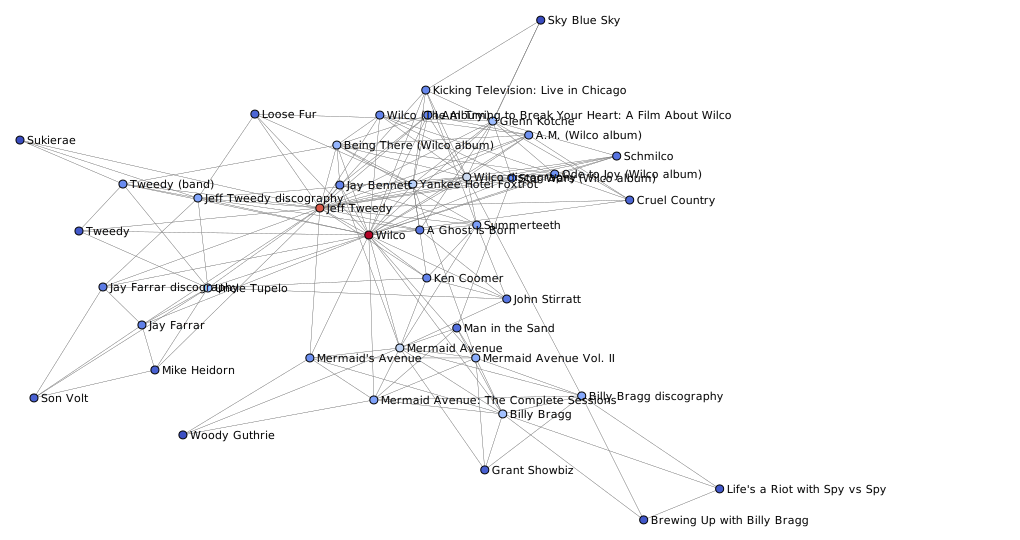

In [27]:
component = components[0]

G = G.subgraph(component) # keep only the wilco nodes

draw_graph(G, node_size=4, font_size=11, show_names=True, edge_width=0.3)

In [113]:
outfile = r'data/wilco_edgelist_clean.csv'

edgelist_df = nx.to_pandas_edgelist(G)
edgelist_df.to_csv(outfile, header=True, index=False)

# Verify Output

It's always a good idea to check that the outfile wrote successfully and is usable. I often do this, after writing data.

In [114]:
pd.read_csv(outfile)

,source,target
0,A.M. (Wilco album),Jeff Tweedy
1,A.M. (Wilco album),Wilco (The Album)
2,A.M. (Wilco album),I Am Trying to Break Your Heart: A Film About ...
3,A.M. (Wilco album),Being There (Wilco album)
4,A.M. (Wilco album),Cruel Country
...,...,...
162,Mike Heidorn,Son Volt
163,Grant Showbiz,Mermaid Avenue Vol. II
164,Jay Farrar discography,Son Volt
165,Being There (Wilco album),Yankee Hotel Foxtrot
